# **RNN PARA PREDICCIÓN DE LOS CASOS DE DENGUE**

## **Importaciones y Configuración**

Realizamos las importaciones necesarias para el desarrollo del modelo SimpleRNN, incluyendo librerías para procesamiento de datos (pandas, numpy), construcción del modelo (tensorflow.keras), escalamiento (MinMaxScaler), métricas (mean_squared_error), y visualización (matplotlib).

Además, configuramos la reproducibilidad del experimento estableciendo una semilla fija (SEED = 42) en todas las librerías que manejan aleatoriedad: os, random, numpy y tensorflow. Esto asegura que los resultados puedan ser replicables.

Por último, se definen rutas a los datos (PATH_TRAIN, PATH_TEST), el año de validación (AÑO_VALIDACION = 2021), el parámetro de ventana temporal (LOOK_BACK_GANADOR = 12), y el número de épocas (EPOCHS = 40).

In [ ]:
# --- Celda 1: Importaciones y Configuración ---
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from datetime import datetime
import matplotlib.pyplot as plt

# 1.1. FIJAR SEMILLAS PARA REPRODUCIBILIDAD MÁXIMA
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1.2. CONFIGURACIÓN DEL MODELO
PATH_TRAIN = '../../Datos/df_train.parquet'
PATH_TEST = '../../Datos/df_test.parquet'
AÑO_VALIDACION = 2021
LOOK_BACK_GANADOR = 12 # Usamos el hiperparámetro de tu mejor modelo
EPOCHS = 40 # Usamos el número de épocas que funcionó

tf.keras.backend.clear_session()
print("Configuración lista para el modelo 'SimpleRNN Optimizado'.")

2025-06-29 13:22:16.824078: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 13:22:16.915734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-29 13:22:16.915795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-29 13:22:16.917489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-29 13:22:16.930524: I tensorflow/core/platform/cpu_feature_guar

Configuración lista para el modelo 'SimpleRNN Optimizado'.


## **Carga de Datos**

Se define la función load_data() para cargar los archivos Parquet correspondientes al conjunto de entrenamiento y prueba. Al cargar los datos, estandarizamos los nombres de las columnas a minúsculas para evitar errores por diferencias de capitalización.

Luego, se ejecuta la función y se almacenan los DataFrames en df_train_raw y df_test_original.

In [2]:
# --- Celda 2: Carga de Datos ---
def load_data(path_train, path_test):
    df_train = pd.read_parquet(path_train)
    df_test = pd.read_parquet(path_test)
    for df in [df_train, df_test]: 
        df.columns = [col.lower() for col in df.columns]
    return df_train, df_test

print("Cargando datos...")
df_train_raw, df_test_original = load_data(PATH_TRAIN, PATH_TEST)
print("Datos cargados.")

Cargando datos...
Datos cargados.


## **Feature Engineering**

En esta etapa generamos las variables más relevantes según lo identificado en el EDA. Sabemos que las condiciones climáticas pasadas, como la lluvia y la temperatura, tienen una fuerte correlación con los picos de casos de dengue.

Por eso, implementamos una función que crea rezagos temporales (lags) para estas variables, barrio por barrio. Esto le da al modelo acceso a la memoria climática de las semanas anteriores, lo cual es clave para anticipar brotes. Usamos una ventana de 12 semanas, que fue la que mostró mejor desempeño durante nuestras pruebas, también sustentado por el EDA.

In [3]:
# --- Celda 3: Feature Engineering ---
def create_features(df_train, df_test, max_lag):
    weather_cols = ['lluvia_mean', 'temperatura_mean']
    df_test['dengue'] = np.nan
    df_full = pd.concat([df_train, df_test], ignore_index=True)
    df_full = df_full.sort_values(by=['id_bar', 'anio', 'semana']).reset_index(drop=True)
    for col in weather_cols:
        for i in range(1, max_lag + 1):
            df_full[f'{col}_lag_{i}'] = df_full.groupby('id_bar')[col].shift(i)
    df_full.fillna(0, inplace=True)
    return df_full

print("Creando características con la estrategia ganadora...")
df_full = create_features(df_train_raw.copy(), df_test_original.copy(), LOOK_BACK_GANADOR)
print("Feature Engineering completado.")

Creando características con la estrategia ganadora...
Feature Engineering completado.


## **Definición de Arquitecturas**

Construimos la arquitectura de red neuronal recurrente (SimpleRNN) para predecir los casos de dengue. Se considera que esta arquitectura es adecuada para series temporales porque puede aprender relaciones entre eventos pasados y presentes a lo largo del tiempo.

Usamos dos capas recurrentes, combinadas con Dropout para evitar sobreajuste, y una capa densa final que devuelve la predicción. El modelo está optimizado para minimizar el error cuadrático medio (MSE), en línea con el objetivo de predecir con precisión la magnitud de los brotes.

In [4]:
# --- Celda 4: Definición de Arquitectura ---
def build_simple_rnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(100, return_sequences=True), # Primera capa recurrente
        Dropout(0.3),
        SimpleRNN(50), # Segunda capa recurrente, solo devuelve el estado final
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

print("Arquitectura SimpleRNN definida.")

Arquitectura SimpleRNN definida.


## **Función de Entrenamiento y Validación por barrio**

Según el EDA, cada barrio tiene comportamientos epidemiológicos y climáticos diferentes, por lo que decidimos entrenar y validar modelos específicos por barrio.

Esta celda implementa una función que entrena un modelo con los datos de cada barrio (hasta 2020) y lo valida con los datos de 2021. Así evaluamos si el modelo logra capturar correctamente la dinámica local de los casos de dengue. También permite obtener las predicciones en escala real e identificar la pérdida (loss) de validación para hacer ajustes futuros.

In [5]:
# --- Celda 5: Funcion de Validación por barrio ---
def validate_barrio_performance(df_barrio, look_back):
    train_df = df_barrio[df_barrio['anio'] < AÑO_VALIDACION]
    val_df = df_barrio[df_barrio['anio'] == AÑO_VALIDACION]
    if val_df.empty or len(train_df) < look_back + 5: return None, None, None

    features_to_use = [c for c in df_full.columns if c not in ['id', 'id_bar', 'anio', 'semana']]
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[features_to_use])
    dengue_col_index = features_to_use.index('dengue')

    X_train, y_train, X_val, y_val_seq = [], [], [], []
    for j in range(look_back, len(train_scaled)):
        X_train.append(train_scaled[j-look_back:j])
        y_train.append(train_scaled[j, dengue_col_index])
    
    full_scaled = scaler.transform(df_barrio[features_to_use])
    for idx in val_df.index:
        X_val.append(full_scaled[idx-look_back:idx])
        y_val_seq.append(full_scaled[idx, dengue_col_index]) # Para calcular val_loss
        
    if not X_train or not X_val: return None, None, None
    X_train, y_train, X_val, y_val_seq = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val_seq)

    model = build_simple_rnn_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, validation_data=(X_val, y_val_seq), verbose=0)
    
    preds_scaled = model.predict(X_val, verbose=0)
    dummy = np.zeros((len(preds_scaled), len(features_to_use)))
    dummy[:, dengue_col_index] = preds_scaled.flatten()
    preds_real = scaler.inverse_transform(dummy)[:, dengue_col_index]
    
    return preds_real, history.history, val_df['dengue'].values

print("Función de validación por barrio definida.")

Función de validación por barrio definida.


## **Aplicaicón de la función de entrenamiento y validación en todos los barrios**

Aplicamos la función de validación (definida anteriormente) a cada barrio de forma individual. La decisión de entrenar modelos específicos por barrio se basa en lo que vimos en el EDA: los patrones de brote y clima varían considerablemente entre barrios, por lo que un modelo global podría no ser lo suficientemente sensible.

Esta validación usa datos hasta 2020 para entrenar y valida con el año 2021, permitiéndonos evaluar el comportamiento del modelo en datos no vistos. Al finalizar, almacenamos para cada barrio las predicciones, los valores reales y el historial de entrenamiento en el diccionario validation_results, lo que nos facilitará la visualización y el análisis posteriores.

In [6]:
# --- Celda 6: Entrenar todos los Barrios (Validación) ---
validation_results = {}
barrios = df_full['id_bar'].unique()

print("--- Iniciando Validación del Modelo SimpleRNN ---")
for i, barrio_id in enumerate(barrios):
    print(f"\r  -> Validando en Barrio {i+1}/{len(barrios)}", end="")
    df_barrio = df_full[df_full['id_bar'] == barrio_id].copy().reset_index(drop=True)
    preds, history, real = validate_barrio_performance(df_barrio, LOOK_BACK_GANADOR)
    if preds is not None:
        validation_results[barrio_id] = {'preds': preds, 'real': real, 'history': history}
print("\nValidación completada.")

--- Iniciando Validación del Modelo SimpleRNN ---
  -> Validando en Barrio 1/10

2025-06-29 13:22:22.980902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 13:22:23.205224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 13:22:23.205370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 13:22:23.209888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-29 13:22:23.210024: I external/local_xla/xla/stream_executor

  -> Validando en Barrio 5/10WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x71f452ac5240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
  -> Validando en Barrio 6/10WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x71f4a896b1c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) c

## **Visualización de predicciones**

Aquí seleccionamos un barrio específico (en este caso, el barrio 3) para visualizar cómo se comportó el modelo en la validación. Se grafican las predicciones del modelo frente a los datos reales de casos de dengue durante 2021, junto con el valor del MSE (error cuadrático medio).

Este gráfico es fundamental para evaluar si el modelo está capturando correctamente los picos y valles del comportamiento epidémico, tal como se identificó en el EDA. Nos ayuda a confirmar visualmente si el modelo logra reproducir la estacionalidad y anticipar los aumentos de casos en un entorno realista.

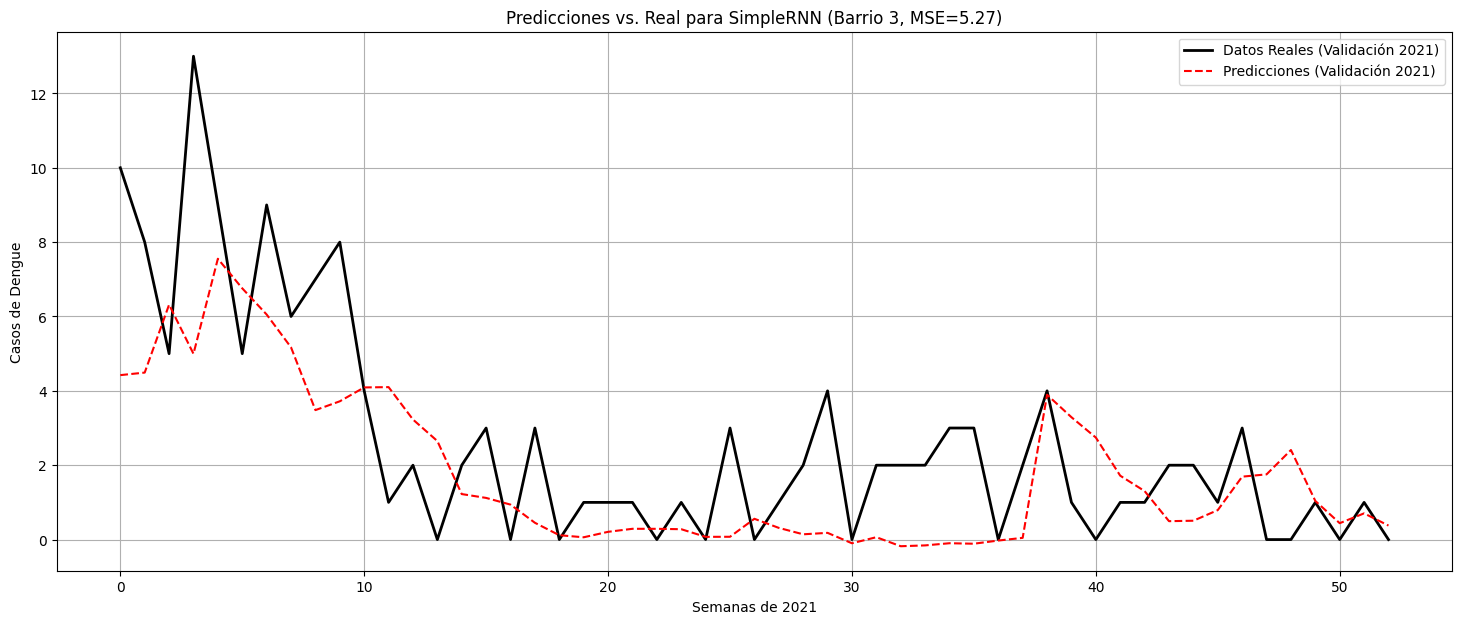

In [7]:
# --- Celda 7: Visualización de predicciones ---
barrio_ejemplo = 3 # Analizamos un barrio de interés
if barrio_ejemplo in validation_results:
    data = validation_results[barrio_ejemplo]
    mse_val = mean_squared_error(data['real'], data['preds'])
    
    plt.figure(figsize=(18, 7))
    plt.plot(data['real'], label='Datos Reales (Validación 2021)', color='black', linewidth=2)
    plt.plot(data['preds'], label=f'Predicciones (Validación 2021)', color='red', linestyle='--')
    plt.title(f'Predicciones vs. Real para SimpleRNN (Barrio {barrio_ejemplo}, MSE={mse_val:.2f})')
    plt.xlabel('Semanas de 2021'), plt.ylabel('Casos de Dengue'), plt.legend(), plt.grid(True)
    plt.show()

En el caso del barrio 3, el modelo SimpleRNN logró capturar de manera aceptable la dinámica general de los casos de dengue durante 2021. Aunque no alcanzó con precisión los picos más altos, sí respetó la forma de la serie y anticipó correctamente las fases de descenso y estabilidad. Este comportamiento refleja la tendencia natural del modelo a suavizar las predicciones, lo cual reduce el error medio (MSE = 5.27) pero limita su sensibilidad ante fluctuaciones abruptas. Aun así, el resultado es prometedor y demuestra que el modelo logra aprender patrones relevantes a partir de los rezagos climáticos y la estructura temporal del brote.

## **Visualización Curva de Loss**

 Generamos la curva de pérdida del modelo para un barrio específico (en este caso, el barrio 3). Utilizamos el historial de entrenamiento guardado durante la validación para graficar la evolución de la pérdida tanto en entrenamiento como en validación a lo largo de las épocas. 
 
 Esta visualización es clave para evaluar si el modelo está aprendiendo correctamente, si hay sobreajuste o si el entrenamiento fue estable. Usamos escala logarítmica para una mejor visualización de las diferencias, especialmente en valores bajos de MSE.

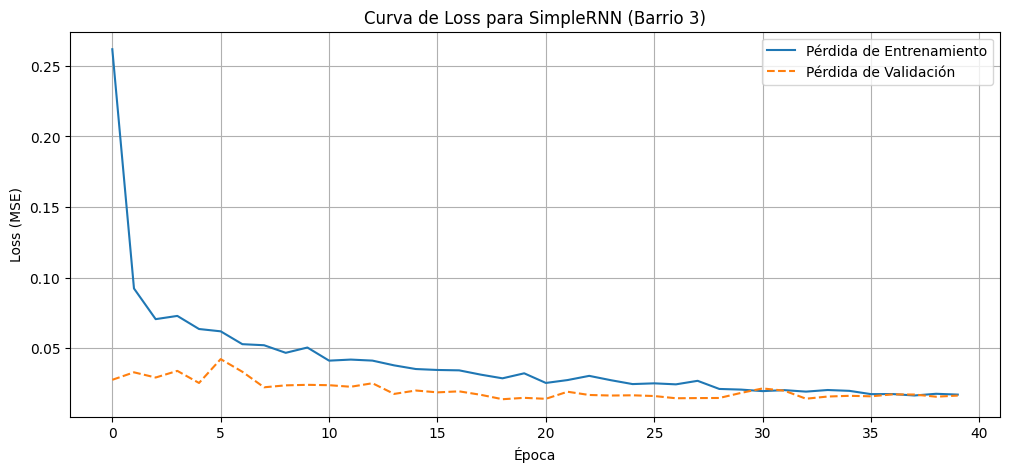

In [8]:
# --- Celda 8: Visualización Curva de Loss ---
barrio_ejemplo = 3
if barrio_ejemplo in validation_results:
    history_to_plot = validation_results[barrio_ejemplo]['history']
    
    plt.figure(figsize=(12, 5))
    plt.plot(history_to_plot['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history_to_plot['val_loss'], label='Pérdida de Validación', linestyle='--')
    plt.title(f'Curva de Loss para SimpleRNN (Barrio {barrio_ejemplo})')
    plt.xlabel('Época'), plt.ylabel('Loss (MSE)'), plt.legend(), plt.grid(True)
    plt.show()

La gráfica muestra una evolución clara y saludable del proceso de entrenamiento. La pérdida en entrenamiento (línea azul) desciende rápidamente en las primeras épocas, lo que indica que el modelo aprendió patrones relevantes desde el inicio. A partir de la época 10, ambas curvas —entrenamiento y validación— se estabilizan y convergen hacia valores bajos y similares.

Este comportamiento es una buena señal: sugiere que no hay sobreajuste, ya que el modelo generaliza bien en los datos de validación. Además, el hecho de que la pérdida de validación sea incluso ligeramente menor que la de entrenamiento en varias épocas puede deberse a la naturaleza estocástica del entrenamiento o a la regularización implícita de los datos.

En conjunto, esta curva refuerza la solidez del modelo SimpleRNN en este barrio: es estable, aprende bien y logra generalizar sin memorizar el ruido.

# Generar Submissions

En esta etapa entrenamos el modelo SimpleRNN para cada barrio, utilizando todos los datos históricos hasta 2021. Escalamos las variables, generamos las secuencias con la ventana temporal definida, y entrenamos un modelo especializado por barrio. 

Finalmente, usamos este modelo para predecir los casos de dengue en 2022 y revertimos las transformaciones para recuperar la escala original.

In [9]:
# --- Celda 9: Generar Submission Final ---
print("\n--- Entrenamiento Final con TODA la historia (2015-2021) ---")
final_predictions = {}
for i, barrio_id in enumerate(barrios):
    print(f"\r  -> Entrenando especialista final para Barrio {i+1}/{len(barrios)}", end="")
    
    df_barrio = df_full[df_full['id_bar'] == barrio_id].copy().reset_index(drop=True)
    train_df = df_barrio[df_barrio['anio'] < 2022]
    test_df = df_barrio[df_barrio['anio'] == 2022]

    if len(train_df) < LOOK_BACK_GANADOR + 5:
        preds_real = np.zeros(len(test_df))
    else:
        features_to_use = [c for c in df_full.columns if c not in ['id', 'id_bar', 'anio', 'semana']]
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_df[features_to_use])
        dengue_col_index = features_to_use.index('dengue')
        X_train, y_train = [], []
        for j in range(LOOK_BACK_GANADOR, len(train_scaled)):
            X_train.append(train_scaled[j-LOOK_BACK_GANADOR:j])
            y_train.append(train_scaled[j, dengue_col_index])
        X_train, y_train = np.array(X_train), np.array(y_train)

        model = build_simple_rnn_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, verbose=0)
        
        full_scaled = scaler.transform(df_barrio[features_to_use])
        test_sequences = []
        for idx in test_df.index:
            test_sequences.append(full_scaled[idx-LOOK_BACK_GANADOR:idx])
        
        preds_scaled = model.predict(np.array(test_sequences), verbose=0)
        dummy_preds = np.zeros((len(preds_scaled), len(features_to_use)))
        dummy_preds[:, dengue_col_index] = preds_scaled.flatten()
        preds_real = scaler.inverse_transform(dummy_preds)[:, dengue_col_index]
        
    for k, pred in enumerate(preds_real.flatten()):
        submission_id = test_df['id'].iloc[k]
        final_predictions[submission_id] = pred
print("\nEntrenamiento final completado.")


--- Entrenamiento Final con TODA la historia (2015-2021) ---
  -> Entrenando especialista final para Barrio 10/10
Entrenamiento final completado.


# Guardar Resultados

Finalmente tomamos las predicciones del paso anterior, las organizamos en el formato requerido, corregimos posibles valores negativos, redondeamos a dos decimales y guardamos el archivo .csv final.

In [10]:
# --- Celda 10: Guardar Submission ---
df_submission_final = df_test_original[['id']].copy()
df_submission_final['dengue'] = df_submission_final['id'].map(final_predictions)
df_submission_final['dengue'] = df_submission_final['dengue'].clip(lower=0).fillna(0)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_filename = f"submission_SimpleRNN_{timestamp}.csv"
df_submission_final.to_csv(submission_filename, index=False)

print(f"\nArchivo final '{submission_filename}' generado con éxito.")
print("Primeras 5 filas de la predicción:")
print(df_submission_final.head())


Archivo final 'submission_SimpleRNN_20250624_204807.csv' generado con éxito.
Primeras 5 filas de la predicción:
             id    dengue
3680  4_2022_01  0.784286
3681  5_2022_01  0.000000
3682  3_2022_01  0.907449
3683  8_2022_01  0.019519
3684  9_2022_01  1.082315
